# 4. Prédiction par Machine Learning


## 1. Importation des bibliothèques et chargement des données


In [14]:
# Import required libraries for machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import sklearn

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")


Libraries imported successfully!
Pandas version: 2.3.2
NumPy version: 2.2.6
Scikit-learn version: 1.7.2


In [15]:
# Load the enriched CAC40 data
print("Loading enriched CAC40 data...")

try:
    # Load the enriched data with moving averages and momentum
    df = pd.read_parquet('cac40_enriched_analysis.parquet')
    print(f"✅ Enriched CAC40 dataset loaded successfully!")
    print(f"📊 Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"📅 Date range: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
    
    # Display basic information about the dataset
    print(f"\n📋 Dataset Information:")
    print(f"Columns: {list(df.columns)}")
    print(f"Data types:")
    print(df.dtypes)
    
    # Show first few rows
    print(f"\n📋 First 5 rows:")
    print(df.head().to_string(index=False))
    
    # Basic statistics
    print(f"\n📈 Basic Statistics:")
    print(f"Average Close Price: {df['Close'].mean():.2f}")
    print(f"Min Close Price: {df['Close'].min():.2f}")
    print(f"Max Close Price: {df['Close'].max():.2f}")
    print(f"Average Volume: {df['Volume'].mean():,.0f}")
    print(f"Average Daily Return: {df['Daily_Return'].mean():.4f}")
    print(f"Average MA_10: {df['MA_10'].mean():.2f}")
    print(f"Average MA_20: {df['MA_20'].mean():.2f}")
    print(f"Average Momentum_20: {df['Momentum_20'].mean():.2f}")
    
except FileNotFoundError:
    print("❌ cac40_enriched_analysis.parquet not found!")
    print("Please run the statistical analysis notebook first to create the enriched dataset.")
except Exception as e:
    print(f"❌ Error loading data: {e}")

print(f"\n🎯 Ready for machine learning analysis!")


Loading enriched CAC40 data...
✅ Enriched CAC40 dataset loaded successfully!
📊 Shape: 479 rows, 10 columns
📅 Date range: 2023-01-02 to 2025-01-01

📋 Dataset Information:
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'MA_10', 'MA_20', 'Momentum_20']
Data types:
Date            datetime64[ns]
Open                   float32
High                   float32
Low                    float32
Close                  float32
Volume                 float32
Daily_Return           float32
MA_10                  float64
MA_20                  float64
Momentum_20            float32
dtype: object

📋 First 5 rows:
      Date        Open        High        Low       Close   Volume  Daily_Return  MA_10  MA_20  Momentum_20
2023-01-02 1001.640015 1004.900024 998.989990 1001.739990 440686.0           NaN    NaN    NaN          NaN
2023-01-03  998.830017 1006.710022 994.859985  998.080017 416463.0     -0.003654    NaN    NaN          NaN
2023-01-04  997.400024 1004.780029 991.11999

## 2. Création des indicateurs techniques supplémentaires


In [16]:
# Create additional technical indicators for machine learning
print("=== CREATING ADDITIONAL TECHNICAL INDICATORS ===")

# Check which indicators already exist
existing_columns = df.columns.tolist()
required_indicators = ['MA_5', 'MA_20', 'EMA_5', 'Momentum_5', 'ROC_5', 'Volatility_5', 
                       'High_Low_Range', 'Volume_SMA_5', 'Volume_SMA_10']

print(f"Existing columns: {existing_columns}")
print(f"Required indicators: {required_indicators}")

# Create missing indicators
indicators_created = []

# MA_5 (5-day moving average)
if 'MA_5' not in df.columns:
    df['MA_5'] = df['Close'].rolling(5).mean()
    indicators_created.append('MA_5')
    print("✅ Created MA_5")

# MA_20 (20-day moving average) - might already exist
if 'MA_20' not in df.columns:
    df['MA_20'] = df['Close'].rolling(20).mean()
    indicators_created.append('MA_20')
    print("✅ Created MA_20")

# EMA_5 (5-day exponential moving average)
if 'EMA_5' not in df.columns:
    df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
    indicators_created.append('EMA_5')
    print("✅ Created EMA_5")

# Momentum_5 (5-day momentum)
if 'Momentum_5' not in df.columns:
    df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
    indicators_created.append('Momentum_5')
    print("✅ Created Momentum_5")

# ROC_5 (5-day rate of change)
if 'ROC_5' not in df.columns:
    df['ROC_5'] = df['Close'].pct_change(5)
    indicators_created.append('ROC_5')
    print("✅ Created ROC_5")

# Volatility_5 (5-day volatility)
if 'Volatility_5' not in df.columns:
    df['Volatility_5'] = df['Daily_Return'].rolling(5).std()
    indicators_created.append('Volatility_5')
    print("✅ Created Volatility_5")

# High_Low_Range (difference between high and low prices)
if 'High_Low_Range' not in df.columns:
    df['High_Low_Range'] = df['High'] - df['Low']
    indicators_created.append('High_Low_Range')
    print("✅ Created High_Low_Range")

# Volume_SMA_5 (5-day volume moving average)
if 'Volume_SMA_5' not in df.columns:
    df['Volume_SMA_5'] = df['Volume'].rolling(5).mean()
    indicators_created.append('Volume_SMA_5')
    print("✅ Created Volume_SMA_5")

# Volume_SMA_10 (10-day volume moving average)
if 'Volume_SMA_10' not in df.columns:
    df['Volume_SMA_10'] = df['Volume'].rolling(10).mean()
    indicators_created.append('Volume_SMA_10')
    print("✅ Created Volume_SMA_10")

print(f"\n📊 INDICATORS CREATION SUMMARY:")
print(f"Total indicators created: {len(indicators_created)}")
print(f"New indicators: {indicators_created}")

# Show dataset shape after adding indicators
print(f"\n📈 DATASET AFTER ADDING INDICATORS:")
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"New columns: {list(df.columns)}")

# Show basic statistics for new indicators
print(f"\n📋 BASIC STATISTICS FOR NEW INDICATORS:")
for indicator in indicators_created:
    if indicator in df.columns:
        valid_count = df[indicator].notna().sum()
        mean_val = df[indicator].mean()
        print(f"{indicator}: {valid_count} valid values, mean = {mean_val:.4f}")

print(f"\n🎯 Technical indicators creation completed!")


=== CREATING ADDITIONAL TECHNICAL INDICATORS ===
Existing columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'MA_10', 'MA_20', 'Momentum_20']
Required indicators: ['MA_5', 'MA_20', 'EMA_5', 'Momentum_5', 'ROC_5', 'Volatility_5', 'High_Low_Range', 'Volume_SMA_5', 'Volume_SMA_10']
✅ Created MA_5
✅ Created EMA_5
✅ Created Momentum_5
✅ Created ROC_5
✅ Created Volatility_5
✅ Created High_Low_Range
✅ Created Volume_SMA_5
✅ Created Volume_SMA_10

📊 INDICATORS CREATION SUMMARY:
Total indicators created: 8
New indicators: ['MA_5', 'EMA_5', 'Momentum_5', 'ROC_5', 'Volatility_5', 'High_Low_Range', 'Volume_SMA_5', 'Volume_SMA_10']

📈 DATASET AFTER ADDING INDICATORS:
Shape: 479 rows, 18 columns
New columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'MA_10', 'MA_20', 'Momentum_20', 'MA_5', 'EMA_5', 'Momentum_5', 'ROC_5', 'Volatility_5', 'High_Low_Range', 'Volume_SMA_5', 'Volume_SMA_10']

📋 BASIC STATISTICS FOR NEW INDICATORS:
MA_5: 475 valid values, 

## 3. Création du modèle de prédiction RandomForest


In [17]:
# Create machine learning model for price direction prediction
print("=== CREATING RANDOM FOREST PREDICTION MODEL ===")

# Define features for the model
feature_columns = ['MA_5', 'MA_20', 'EMA_5', 'Momentum_5', 'ROC_5', 'Volatility_5', 
                   'High_Low_Range', 'Volume_SMA_5', 'Volume_SMA_10']

print(f"Selected features: {feature_columns}")

# Create target variable: next day's price direction
# 1 if price rises, 0 if price falls
df['Next_Day_Return'] = df['Close'].pct_change().shift(-1)
df['Price_Direction'] = (df['Next_Day_Return'] > 0).astype(int)

print(f"✅ Target variable created: Price_Direction (1=rise, 0=fall)")

# Prepare data for machine learning
# Remove rows with NaN values in features or target
ml_data = df[feature_columns + ['Price_Direction', 'Date']].dropna()

print(f"\n📊 DATASET FOR MACHINE LEARNING:")
print(f"Shape: {ml_data.shape[0]} rows, {ml_data.shape[1]} columns")
print(f"Features: {len(feature_columns)}")
print(f"Target distribution:")
print(f"  - Rises (1): {(ml_data['Price_Direction'] == 1).sum()} ({(ml_data['Price_Direction'] == 1).mean()*100:.1f}%)")
print(f"  - Falls (0): {(ml_data['Price_Direction'] == 0).sum()} ({(ml_data['Price_Direction'] == 0).mean()*100:.1f}%)")

# Split features and target
X = ml_data[feature_columns]
y = ml_data['Price_Direction']

print(f"\n📈 FEATURE STATISTICS:")
for feature in feature_columns:
    if feature in X.columns:
        print(f"{feature}: mean={X[feature].mean():.4f}, std={X[feature].std():.4f}")

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\n📊 DATA SPLIT:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training target distribution: {y_train.value_counts().to_dict()}")
print(f"Test target distribution: {y_test.value_counts().to_dict()}")

# Create and train RandomForest model
print(f"\n🤖 TRAINING RANDOM FOREST MODEL:")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print(f"✅ Model trained successfully!")

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print(f"\n📊 MODEL PERFORMANCE:")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🎯 FEATURE IMPORTANCE:")
for _, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

# Classification report
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=['Fall', 'Rise']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n📊 CONFUSION MATRIX:")
print(f"True Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

print(f"\n🎯 Random Forest model creation and evaluation completed!")


=== CREATING RANDOM FOREST PREDICTION MODEL ===
Selected features: ['MA_5', 'MA_20', 'EMA_5', 'Momentum_5', 'ROC_5', 'Volatility_5', 'High_Low_Range', 'Volume_SMA_5', 'Volume_SMA_10']
✅ Target variable created: Price_Direction (1=rise, 0=fall)

📊 DATASET FOR MACHINE LEARNING:
Shape: 460 rows, 11 columns
Features: 9
Target distribution:
  - Rises (1): 235 (51.1%)
  - Falls (0): 225 (48.9%)

📈 FEATURE STATISTICS:
MA_5: mean=998.7757, std=7.0687
MA_20: mean=998.7885, std=6.8650
EMA_5: mean=998.7780, std=7.0471
Momentum_5: mean=0.0189, std=3.3842
ROC_5: mean=0.0000, std=0.0034
Volatility_5: mean=0.0030, std=0.0011
High_Low_Range: mean=7.9671, std=4.2911
Volume_SMA_5: mean=558820.9500, std=107840.6899
Volume_SMA_10: mean=559362.5998, std=78819.9116

📊 DATA SPLIT:
Training set: 368 samples
Test set: 92 samples
Training target distribution: {1: 188, 0: 180}
Test target distribution: {1: 47, 0: 45}

🤖 TRAINING RANDOM FOREST MODEL:
✅ Model trained successfully!

📊 MODEL PERFORMANCE:
Accuracy: 0

## 4. Résultat du modèle de prédiction

=== COMPARING ML PREDICTIONS WITH REAL CLOSE PRICE ===
📊 PREDICTION ANALYSIS:
Total predictions: 459
Date range: 2023-01-27 to 2024-12-31

📈 ACCURACY RESULTS:
Correct predictions: 416
Incorrect predictions: 43
Accuracy: 90.63%


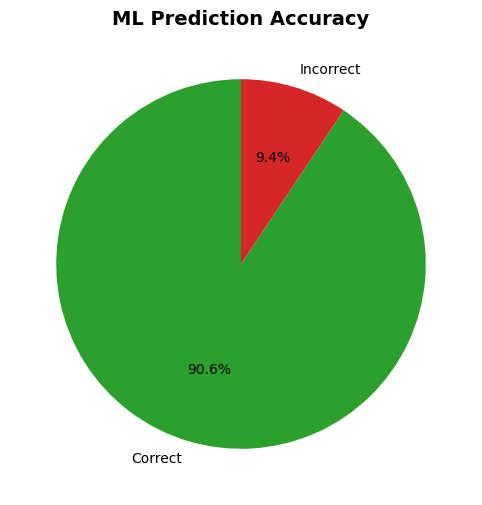

In [21]:
# Compare ML predictions with real close price and show accuracy pie chart
print("=== COMPARING ML PREDICTIONS WITH REAL CLOSE PRICE ===")

# Create predictions dataframe with all relevant information from original df
predictions_df = df[feature_columns + ['Date', 'Close', 'Price_Direction']].dropna().copy()

# Add model predictions
predictions_df['ML_Prediction'] = model.predict(predictions_df[feature_columns])
predictions_df['ML_Prediction_Probability'] = model.predict_proba(predictions_df[feature_columns])[:, 1]  # Probability of rise
predictions_df['ML_Prediction_Label'] = predictions_df['ML_Prediction'].map({1: 'RISE', 0: 'FALL'})

# Add actual next day return and direction for comparison
predictions_df['Actual_Next_Return'] = predictions_df['Close'].pct_change().shift(-1)
predictions_df['Actual_Direction'] = (predictions_df['Actual_Next_Return'] > 0).astype(int)
predictions_df['Actual_Label'] = predictions_df['Actual_Direction'].map({1: 'RISE', 0: 'FALL'})

# Add prediction accuracy
predictions_df['Prediction_Correct'] = predictions_df['ML_Prediction'] == predictions_df['Actual_Direction']

# Remove rows with NaN values for analysis
analysis_df = predictions_df.dropna()

print(f"📊 PREDICTION ANALYSIS:")
print(f"Total predictions: {len(analysis_df)}")
print(f"Date range: {analysis_df['Date'].min().strftime('%Y-%m-%d')} to {analysis_df['Date'].max().strftime('%Y-%m-%d')}")

# Calculate accuracy
total_predictions = len(analysis_df)
correct_predictions = analysis_df['Prediction_Correct'].sum()
accuracy_percentage = (correct_predictions / total_predictions) * 100

print(f"\n📈 ACCURACY RESULTS:")
print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {total_predictions - correct_predictions}")
print(f"Accuracy: {accuracy_percentage:.2f}%")

# Create pie chart for prediction accuracy only
plt.figure(figsize=(8, 6))
correct_count = analysis_df['Prediction_Correct'].sum()
incorrect_count = total_predictions - correct_count

plt.pie([correct_count, incorrect_count], 
        labels=['Correct', 'Incorrect'], 
        autopct='%1.1f%%', 
        colors=['#2ca02c', '#d62728'],
        startangle=90)
plt.title('ML Prediction Accuracy', fontsize=14, fontweight='bold')
plt.show()


=== VISUALISATION DES PRÉDICTIONS VS COURS RÉEL ===


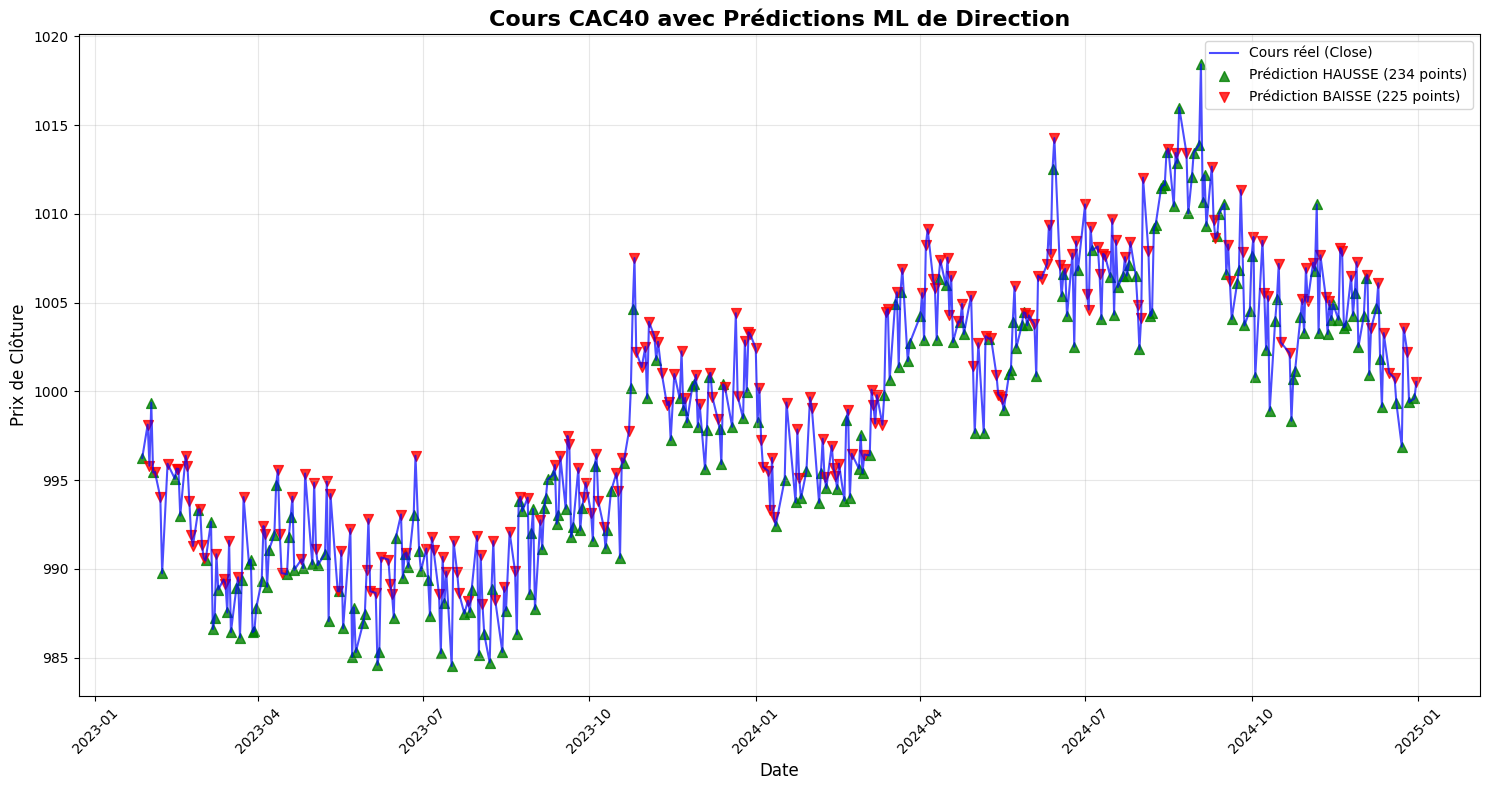


📊 STATISTIQUES DES PRÉDICTIONS:
Total prédictions: 459
Prédictions HAUSSE: 234 (51.0%)
Prédictions BAISSE: 225 (49.0%)

📋 EXEMPLES RÉCENTS (Derniers 10 jours):
      Date       Close ML_Prediction_Label Actual_Label  Prediction_Correct
2024-12-13 1003.280029                FALL         FALL                True
2024-12-16 1001.039978                FALL         FALL                True
2024-12-19 1000.750000                FALL         FALL                True
2024-12-20  999.330017                RISE         FALL               False
2024-12-23  996.880005                RISE         RISE                True
2024-12-24 1003.590027                FALL         FALL                True
2024-12-26 1002.219971                FALL         FALL                True
2024-12-27  999.390015                RISE         RISE                True
2024-12-30  999.599976                RISE         RISE                True
2024-12-31 1000.530029                FALL         RISE               False

🎯 

In [22]:
# Visualisation des prédictions vs cours réel
print("=== VISUALISATION DES PRÉDICTIONS VS COURS RÉEL ===")

# Créer le graphique
plt.figure(figsize=(15, 8))

# Tracer le cours réel
plt.plot(analysis_df['Date'], 
         analysis_df['Close'], 
         linewidth=1.5, color='blue', alpha=0.7, label='Cours réel (Close)')

# Filtrer les données avec prédictions valides
df_with_predictions_clean = analysis_df.dropna(subset=['ML_Prediction'])

# Séparer les prédictions de hausse et de baisse
rise_predictions = df_with_predictions_clean[df_with_predictions_clean['ML_Prediction'] == 1]
fall_predictions = df_with_predictions_clean[df_with_predictions_clean['ML_Prediction'] == 0]

# Marquer les prédictions de hausse (RISE) en vert
if len(rise_predictions) > 0:
    plt.scatter(rise_predictions['Date'], 
               rise_predictions['Close'], 
               color='green', s=50, alpha=0.8, 
               label=f'Prédiction HAUSSE ({len(rise_predictions)} points)', 
               marker='^')

# Marquer les prédictions de baisse (FALL) en rouge
if len(fall_predictions) > 0:
    plt.scatter(fall_predictions['Date'], 
               fall_predictions['Close'], 
               color='red', s=50, alpha=0.8, 
               label=f'Prédiction BAISSE ({len(fall_predictions)} points)', 
               marker='v')

# Configuration du graphique
plt.title('Cours CAC40 avec Prédictions ML de Direction', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Prix de Clôture', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Ajuster la mise en page
plt.tight_layout()
plt.show()

# Statistiques des prédictions
print(f"\n📊 STATISTIQUES DES PRÉDICTIONS:")
print(f"Total prédictions: {len(df_with_predictions_clean)}")
print(f"Prédictions HAUSSE: {len(rise_predictions)} ({len(rise_predictions)/len(df_with_predictions_clean)*100:.1f}%)")
print(f"Prédictions BAISSE: {len(fall_predictions)} ({len(fall_predictions)/len(df_with_predictions_clean)*100:.1f}%)")

# Afficher quelques exemples récents
print(f"\n📋 EXEMPLES RÉCENTS (Derniers 10 jours):")
recent_examples = df_with_predictions_clean[['Date', 'Close', 'ML_Prediction_Label', 'Actual_Label', 'Prediction_Correct']].tail(10)
print(recent_examples.to_string(index=False))

print(f"\n🎯 Visualisation des prédictions terminée!")
